In [2]:
%pip install q keras==2.2.4
%pip install tensorflow==2.12

     -------------------------------------- 312.5/312.5 kB 6.4 MB/s eta 0:00:00
     -------------------------------------- 152.8/152.8 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 19.1 MB/s eta 0:00:00
     ---------------------------------------- 42.6/42.6 kB ? eta 0:00:00
     ---------------------------------------- 50.7/50.7 kB 2.5 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     -------------------------------------- 272.8/272.8 MB 6.4 MB/s eta 0:00:00
     -------------------------------------- 130.2/130.2 kB 7.5 MB/s eta 0:00:00
     ------------------------------------- 430.5/430.5 kB 26.3 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB ? eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 26.0 MB/s eta 0:00:00
     ---------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [5]:
%pip install scikit-image

     --------------------------------------- 24.5/24.5 MB 23.3 MB/s eta 0:00:00
  Using cached imageio-2.31.5-py3-none-any.whl (313 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached tifffile-2023.9.26-py3-none-any.whl (222 kB)

[notice] A new release of pip available: 22.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
%pip install scikit-learn

     ---------------------------------------- 9.3/9.3 MB 19.9 MB/s eta 0:00:00
     ------------------------------------- 302.2/302.2 kB 19.5 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [9]:
!nvidia-smi

Mon Oct  9 04:45:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8     3W /  N/A |     79MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Preparar datos

In [10]:
X_raw = np.load('X.npy')
X_raw = X_raw/255.
y = np.load('y.npy')
X = []
size = (28,28)
for x in X_raw:
    X.append(resize(x, size))
X = np.array(X)

[]

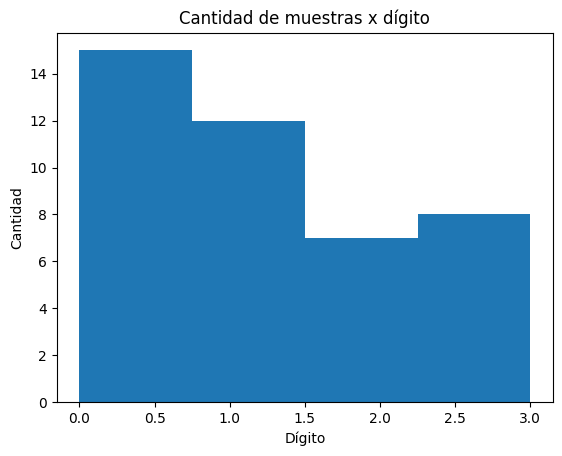

In [11]:
plt.figure()
plt.title("Cantidad de muestras x dígito")
plt.ylabel("Cantidad")
plt.xlabel("Dígito")
plt.hist(y, bins=4)
plt.plot()

### Visualizando el `dataset`

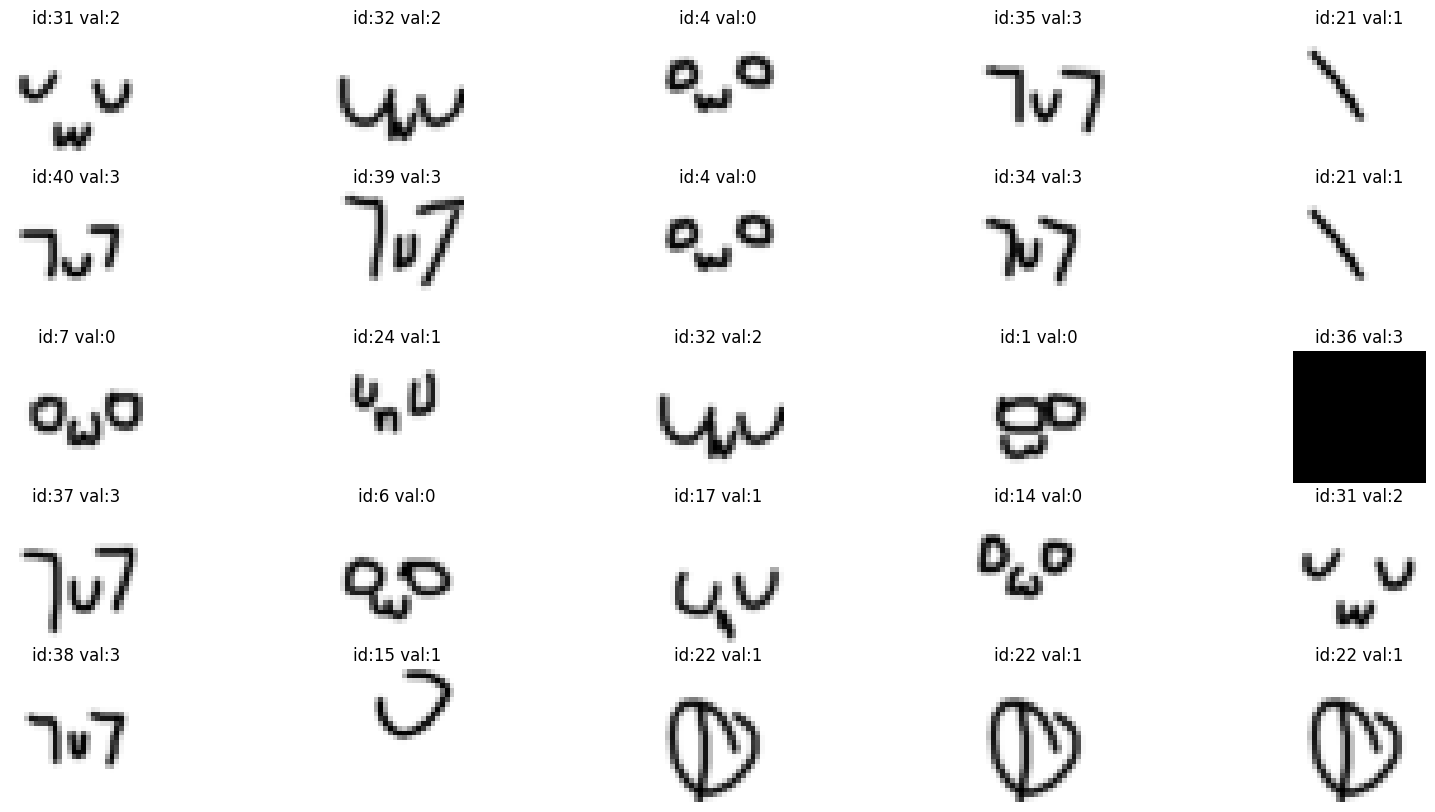

In [12]:
plt.figure(figsize=(20,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    idx = np.random.choice(X.shape[0], 1)[0]
    plt.title('id:{} val:{}'.format(idx, y[idx] ))
    plt.imshow(-X[idx], cmap='gray')
    plt.axis('off')
plt.show()

### Split de train-test

In [13]:
X.shape

(42, 28, 28)

In [14]:
y.shape

(42,)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

[]

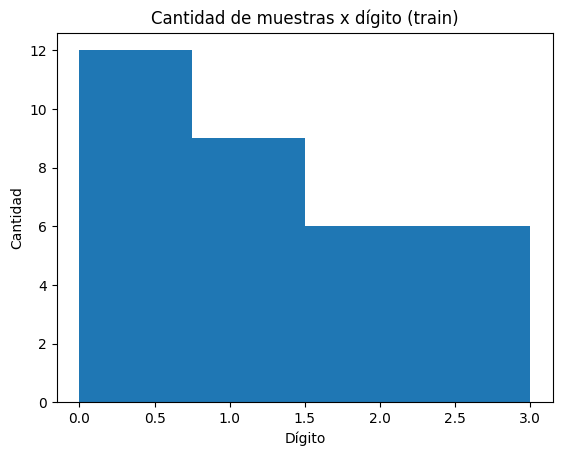

In [16]:
plt.figure()
plt.title("Cantidad de muestras x dígito (train)")
plt.ylabel("Cantidad")
plt.xlabel("Dígito")
plt.hist(y_train, bins=4)
plt.plot()

[]

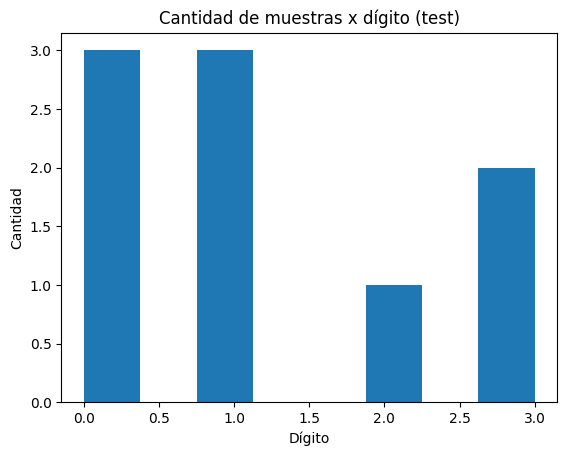

In [17]:
plt.figure()
plt.title("Cantidad de muestras x dígito (test)")
plt.ylabel("Cantidad")
plt.xlabel("Dígito")
plt.hist(y_test, bins=8)
plt.plot()

In [18]:
# Ajustamos las dimensiones de las imágenes
if X_train.ndim == 3:
    X_train = X_train[...,None]
    X_test = X_test[..., None]
    print(X_train.shape, X_test.shape)

(33, 28, 28, 1) (9, 28, 28, 1)


## Definimos un modelo

In [26]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.python.keras.optimizers import gradient_descent_v2


bs = 16
lr = 0.0005

#Espacio de busqueda
#Cantidad Filtros: 32, 64, 128, 256
#Tamaño del Filtro: 3, 5, 7
#Activaciones: 'relu', 'sigmoid', 'tanh'
#Unidades Dense: 128, 256, 100..
#lr: 0.001, 0.0001, 0.00001, etc
#bs: 8, 16, 32...

model = Sequential([Conv2D(32, 3, activation='relu', input_shape=(*size,1)),
                    MaxPool2D(),
                    Conv2D(64, 3, activation='relu', padding ='same'),
                    MaxPool2D(),
                    Conv2D(128, 3, activation='relu', padding ='same'),
                    MaxPool2D(),
                    Flatten(),
                    Dense(128, activation='relu'), #modificar!
                    Dense(4, activation='softmax')]) #no modificar

optimizer1=gradient_descent_v2.SGD(learning_rate=lr)
model.compile(optimizer= optimizer1, loss='sparse_categorical_crossentropy' , metrics=['accuracy'])
# La pérdida 'sparse_categorical_crossentropy' realiza automaticamente la conversión
# del target a one-hot encoding.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [19]:
import numpy as np

print(type(y_train[0]))

<class 'numpy.int64'>


In [28]:
print(y_train)

[2 1 3 2 0 2 0 0 1 3 1 2 0 3 0 1 0 2 1 0 3 3 2 1 0 1 3 0 1 0 1 0 0]


## Entrenamiento

In [27]:
log = model.fit(X_train, y_train, batch_size=bs, epochs=400, validation_data=(X_test, y_test))

Epoch 1/400
3/3 [==============================] - 1s 88ms/step - loss: 1.3869 - accuracy: 0.3030 - val_loss: 1.3798 - val_accuracy: 0.3333
Epoch 2/400
3/3 [==============================] - 0s 20ms/step - loss: 1.3867 - accuracy: 0.3030 - val_loss: 1.3795 - val_accuracy: 0.3333
Epoch 3/400
3/3 [==============================] - 0s 22ms/step - loss: 1.3861 - accuracy: 0.3030 - val_loss: 1.3793 - val_accuracy: 0.3333
Epoch 4/400
3/3 [==============================] - 0s 21ms/step - loss: 1.3859 - accuracy: 0.3030 - val_loss: 1.3791 - val_accuracy: 0.3333
Epoch 5/400
3/3 [==============================] - 0s 22ms/step - loss: 1.3858 - accuracy: 0.3030 - val_loss: 1.3792 - val_accuracy: 0.3333
Epoch 6/400
3/3 [==============================] - 0s 20ms/step - loss: 1.3856 - accuracy: 0.3030 - val_loss: 1.3789 - val_accuracy: 0.3333
Epoch 7/400
3/3 [==============================] - 0s 21ms/step - loss: 1.3849 - accuracy: 0.3030 - val_loss: 1.3786 - val_accuracy: 0.3333
Epoch 8/400
3/3 [===

In [29]:
def show_results(model, log):
    loss, acc = model.evaluate(X_test, y_test, batch_size=512, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    val_loss = log.history['val_loss']
    val_acc = log.history['val_accuracy']
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('acc')
    for ax in axes: ax.legend()

Loss     = 1.3413
Accuracy = 0.3333


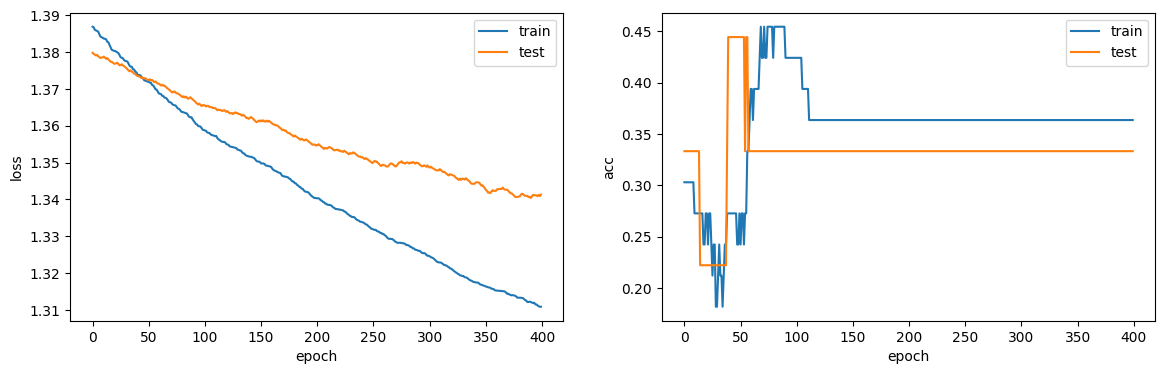

In [30]:
show_results(model, log)

## Probando el modelo

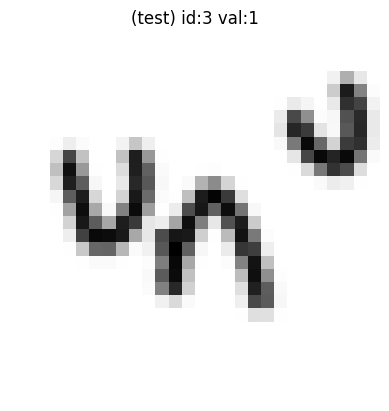

In [31]:
idx = np.random.choice(X_test.shape[0], 1)[0]
im = X_test[idx]
label = y_test[idx]
plt.title('(test) id:{} val:{}'.format(idx, label ))
plt.axis('off')
plt.imshow(-im[:,:,0], cmap='gray')
plt.show()

## Usando el modelo entrenado

In [32]:
salida = model.predict(im[None,:,:,:])[0]
salida

array([0.32050747, 0.2484052 , 0.21626356, 0.21482375], dtype=float32)

[]

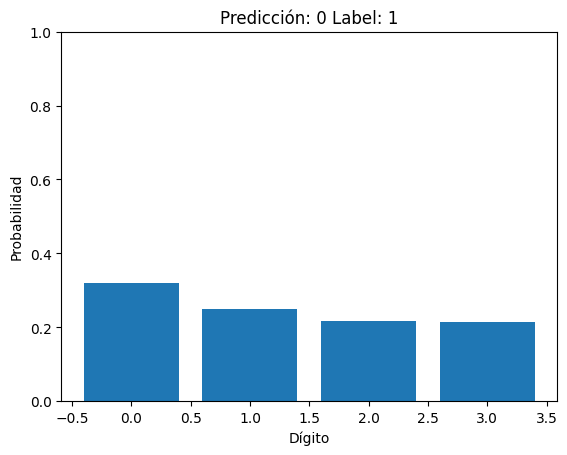

In [33]:
plt.figure()
plt.title("Predicción: {} Label: {}".format(salida.argmax(), label ))
plt.ylabel("Probabilidad")
plt.xlabel("Dígito")
plt.ylim([0,1])
plt.bar(np.arange(4), salida)
plt.plot()